# Emotion prediction using a deep neural network (DNN) with weight sparsity control scheme

This code is to investigate the results of the DNN with weight sparsity control for the prediction of emotion responses using the provided sample data. It is important to check learning curves of the prediction performance obtained from training and test data so that we can justify whether the DNN model properly works or not. In addition, it is necessary to explore the convergence of target sparsity levels in each hidden layer. 


In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the result files

In [0]:
import matplotlib.pyplot as plt
import numpy as np  # Simplification
import scipy.io as sio
import os

data_path = '/content/drive/My Drive/Colab_Notebooks/KHBM2019_MVPA/Regression_of_fMRI_volume/results_20190812_0329/Test_hsp_tg_0.70-0.70-0.70'
trvld_err = sio.loadmat('%s/result_train_err.mat' % (data_path))['trainErr']  # load "error" values
pct_trvld = sio.loadmat('%s/result_train_pct.mat' % (data_path))['trainPct']  # load "predcited emotion scores" 
train_y = sio.loadmat('%s/result_train_ref.mat' % (data_path))['trainRef']  # load "Rated emotion scores" 

ts_err = sio.loadmat('%s/result_test_err.mat' % (data_path))['testErr']  # load "error" values
pct_tst = sio.loadmat('%s/result_test_pct.mat' % (data_path))['testPct']  # load "predicted emotion scores" 
test_y = sio.loadmat('%s/result_test_ref.mat' % (data_path))['testRef']  # load "Rated emotion scores"

hsp_vals = sio.loadmat('%s/result_hsp.mat' % (data_path))['hsp']  # load "Hoyer sparisty levels" 
weights = sio.loadmat('%s/result_weight.mat' % (data_path))['weight']  # load "trained weight parameters"

nepoch = ts_err.shape[1]

## Calculation of Correlation coefficient bewteen rated and predcited emotion responses

In [88]:
tr_cc = np.zeros((nepoch));  ts_cc = np.zeros((nepoch));

for ii in range(nepoch-1):
    tr_r = np.corrcoef(pct_trvld[ii,:].flatten(),train_y.flatten());
    ts_r = np.corrcoef(pct_tst[ii,:].flatten(),test_y.flatten());
    tr_cc[ii] =tr_r[1,0];
    ts_cc[ii] = ts_r[1,0];

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


## Plots of the DNN results

The convergence of the training and test errors should be checked

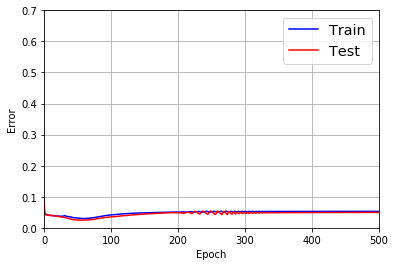

In [89]:
## Plotting DNNP results
t1 = np.arange(0, nepoch, 1)

# Training/test learning curves of the error
plt.figure(1);
plt.plot(t1, trvld_err.flatten(), 'b', label ='Train')
plt.plot(t1, ts_err.flatten(), 'r', label ='Test')
plt.axis([0, nepoch, 0, 0.7]);plt.grid(True)
plt.xlabel('Epoch'); plt.ylabel('Error')
plt.legend(loc='best', fontsize='x-large')
plt.show()

The convergence of the training and test correlation coefficients should be checked

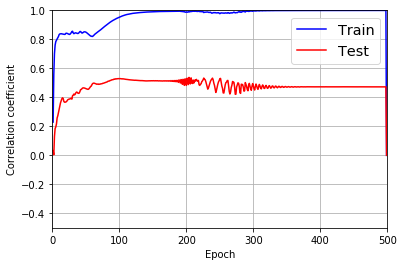

In [90]:
# Training/test learning curves of the correlation coefficient 
plt.figure(2);
plt.plot(t1, tr_cc.flatten(), 'b', label ='Train')
plt.plot(t1, ts_cc.flatten(), 'r', label ='Test')
plt.axis([0, nepoch, -0.5, 1]); plt.grid(True);
plt.xlabel('Epoch'); plt.ylabel('Correlation coefficient')
plt.legend(loc='best', fontsize='x-large')
plt.show()

The sparsity levels are converged to the target sparsity levels of each hidden layer.

(3, 500, 20)


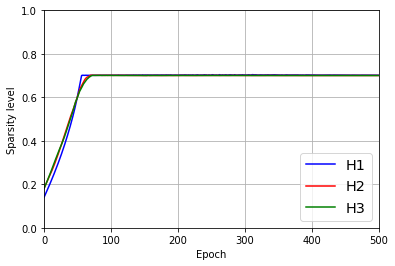

In [91]:
# Sparsity changes over epoch

print(hsp_vals.shape)

plt.figure(3);
plt.plot(t1, np.mean(hsp_vals[0,t1,:],axis=1), 'b',label ='H1'); # hidden layer 1
plt.plot(t1,  np.mean(hsp_vals[1,t1,:],axis=1), '-r',label ='H2'); # hidden layer 2
plt.plot(t1,  np.mean(hsp_vals[2,t1,:],axis=1), '-g',label ='H3'); # hidden layer 3
plt.axis([0, nepoch, 0, 1]);plt.grid(True); 
plt.xlabel('Epoch'); plt.ylabel('Sparsity level')
plt.legend(loc='best', fontsize='x-large')
plt.show()

The following code is to check patterns of the estimated emotion response from training and test data.

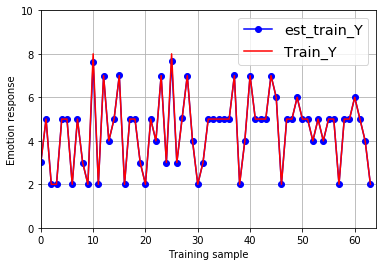

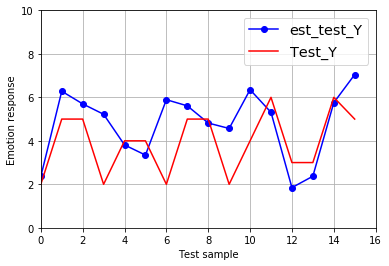

In [92]:
# Plotting of emotion responses and estimated responses obtained from training data

plt.figure(4);

t2 = np.arange(0, pct_trvld.shape[1], 1)

pct_train_y = pct_trvld[nepoch-1,:].flatten()

plt.plot(t2, pct_train_y*10, '-ob', label ='est_train_Y')
plt.plot(t2, train_y.flatten()*10, '-r', label ='Train_Y')
plt.axis([0, pct_trvld.shape[1], 0, 10]); plt.grid(True)

plt.xlabel('Training sample'); plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='x-large')

plt.figure(5);

t3 = np.arange(0, pct_tst.shape[1], 1); 
pct_test_y = pct_tst[nepoch-1,:].flatten();

plt.plot(t3, pct_test_y*10, '-ob', label ='est_test_Y');
plt.plot(t3, test_y.flatten()*10, '-r', label ='Test_Y');
plt.axis([0, pct_tst.shape[1], 0, 10]); plt.grid(True);

plt.xlabel('Test sample'); plt.ylabel('Emotion response');
plt.legend(loc='best', fontsize='x-large');

plt.show()


## Weight feature representation using trained weight parameters

In [93]:
#!pip install nilearn

import nibabel as nib
from nilearn import image
import scipy.stats # This module contains a large number of probability distributions as well as a growing library of statistical functions.

mask_data_path = '/content/drive/My Drive/Colab_Notebooks/KHBM2019_MVPA/Regression_of_fMRI_volume/'
maskimage_mem = image.load_img(os.path.join(mask_data_path, 'mask_map.nii'))

maskimage_mem

mask3d = maskimage_mem.get_data()

# "weights" variable in a cell structure form, which consist of four matrixces [input to output layer] in each cell 
# because this tutorital code uses three-layer DNN, 
W1 = weights[0,0]; # input to 1st
W2 = weights[0,1]; # 1st to 2nd
W3 = weights[0,2]; # 3rd to 4th 
W4 = weights[0,3]; # 4th to last 

print(W1.shape)
print(W2.shape)
print(W3.shape)
print(W4.shape)

(55417, 20)
(20, 20)
(20, 20)
(20, 1)


## How to represent weight features? 

<!DOCTYPE html>
<html>
​
<head>
    <meta charset="utf-8" />
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1">
</head>
​
<body>
    <img src="https://drive.google.com/uc?export=view&id=1Edtz75QYo4nig7QnUdKiNiAHKHMv62Bg">
</body>
​
</html>


# 1st hidden layer: Spatial patterns of weight features 

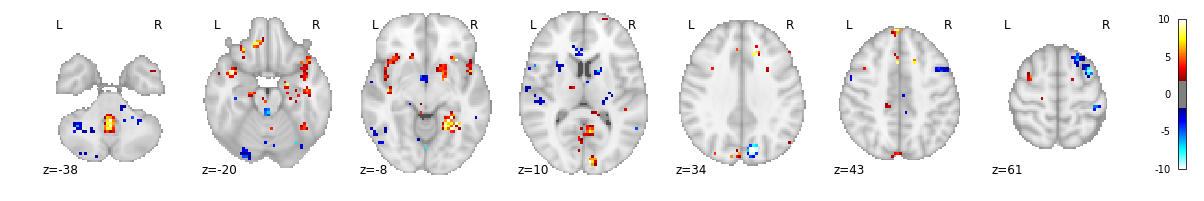

In [98]:
from nilearn import plotting

xdim = 53; ydim = 63; zdim = 46
tg_node = 1

Wf = W1;  z_Wf = scipy.stats.zscore(Wf,axis=0,ddof=1)

Wf_3dmap = np.zeros((xdim,ydim,zdim))
Wf_3dmap[np.nonzero(mask3d)] = z_Wf[:,tg_node]
Wf_map_mem = nib.Nifti1Image(Wf_3dmap,maskimage_mem.affine)

plotting.plot_stat_map(Wf_map_mem,display_mode="z",threshold = 1.96,vmax=10)

# 2nd hidden layer: Spatial patterns of weight features 

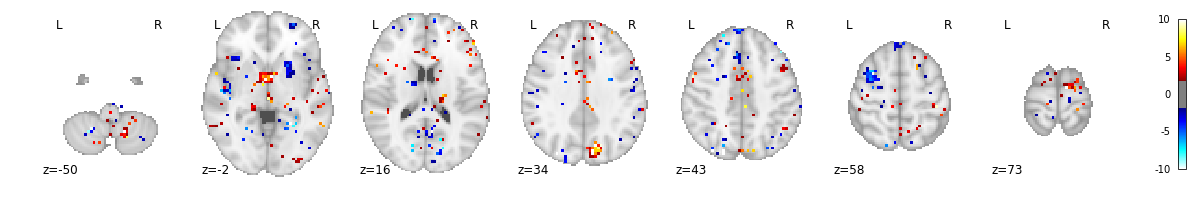

In [102]:
xdim = 53; ydim = 63; zdim = 46
tg_node = 5

W2f = np.inner(W1,W2);  z_W2f = scipy.stats.zscore(W2f,axis=0,ddof=1)

W2f_3dmap = np.zeros((xdim,ydim,zdim))
W2f_3dmap[np.nonzero(mask3d)] = z_W2f[:,tg_node]
W2f_map_mem = nib.Nifti1Image(W2f_3dmap,maskimage_mem.affine)

plotting.plot_stat_map(W2f_map_mem,display_mode="z",threshold = 1.96,vmax=10)

# 3rd hidden layer: Spatial patterns of weight features

(55417, 20)


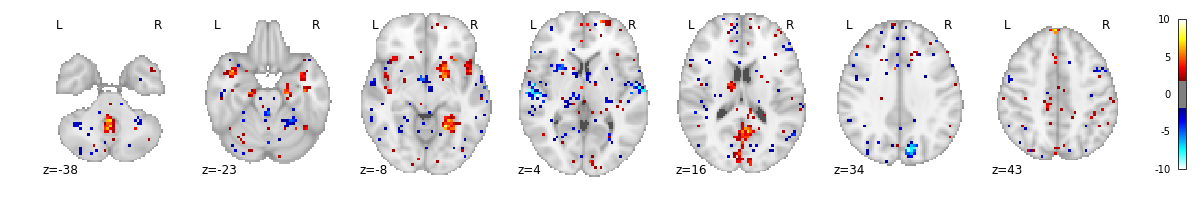

In [105]:
xdim = 53; ydim = 63; zdim = 46
tg_node = 3

W3f = np.inner(W2f,W3);  z_W3f = scipy.stats.zscore(W3f,axis=0,ddof=1)
print(W3f.shape)
W3f_3dmap = np.zeros((xdim,ydim,zdim))
W3f_3dmap[np.nonzero(mask3d)] = z_W3f[:,tg_node]
W3f_map_mem = nib.Nifti1Image(W3f_3dmap,maskimage_mem.affine)

plotting.plot_stat_map(W3f_map_mem,display_mode="z",threshold = 1.96,vmax=10)

# Output layer: Spatial patterns of weight features 

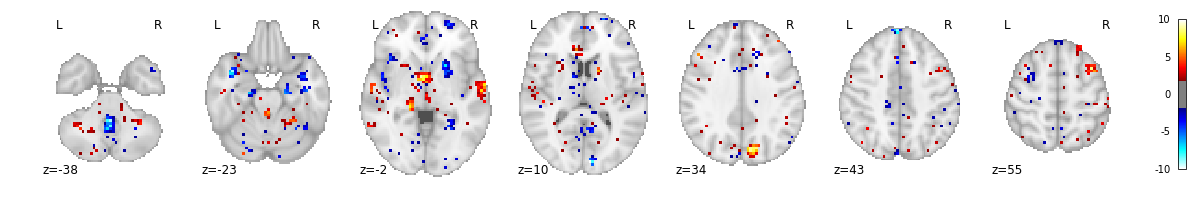

In [106]:
xdim = 53; ydim = 63; zdim = 46

W4f = np.inner(W3f,np.transpose(W4)).flatten();  
z_W4f = scipy.stats.zscore(W4f,axis=0,ddof=1)

W4f_3dmap = np.zeros((xdim,ydim,zdim))
W4f_3dmap[np.nonzero(mask3d)] = z_W4f
W4f_map_mem = nib.Nifti1Image(W4f_3dmap,maskimage_mem.affine)

plotting.plot_stat_map(W4f_map_mem,display_mode="z",threshold = 1.96,vmax=10)